In [1]:
# imports
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np

In [2]:
def get_data():
    x_train_ = pd.read_csv('X_train.csv').drop('id', axis=1)
    y_train_ = pd.read_csv('y_train.csv', usecols=['y'])
    x_test_ = pd.read_csv('X_test.csv').drop('id', axis=1)
    return x_train_, y_train_, x_test_

In [3]:
x_train, y_train, x_test = get_data()

## Missing Values
-for each feature we have less then 10% missing values

In [4]:
# replace missing values with the median
x_train = x_train.fillna(x_train.median())
x_test = x_test.fillna(x_test.median())

## visualize features

In [5]:
x_train.iloc[:,100:110].describe()

,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.0,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000
mean,2090.614702,6261.081342,1050.280057,99754.914817,0.0,10.544738,999.491235,2.255997,10.059474,10505.546410
std,409.197222,832.950641,27.325726,9708.731667,0.0,0.271305,97.094723,0.175139,0.970880,269.005739
min,917.361697,2702.884621,1000.136723,64453.633223,0.0,10.011403,692.134011,1.551175,6.782548,10002.434495
25%,1821.070358,5795.301285,1028.057834,94125.981899,0.0,10.335345,940.802831,2.160009,9.436043,10295.154295
50%,2068.024479,6216.291880,1050.921684,99685.350103,0.0,10.539937,997.862236,2.266434,10.096081,10503.092428
75%,2326.126335,6777.070848,1072.985808,105145.955580,0.0,10.755371,1061.443578,2.359351,10.671460,10714.486388
max,3835.545589,10846.031608,1099.560512,131891.461479,0.0,11.086188,1398.416884,2.895438,13.094450,10998.836370


In [6]:
x_train.iloc[:,104]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1207    0.0
1208    0.0
1209    0.0
1210    0.0
1211    0.0
Name: x104, Length: 1212, dtype: float64

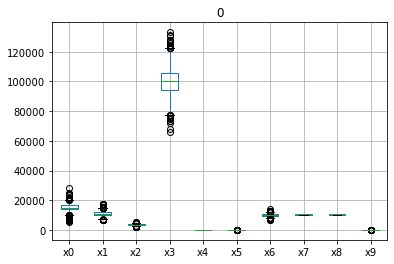

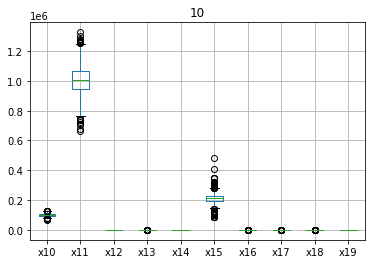

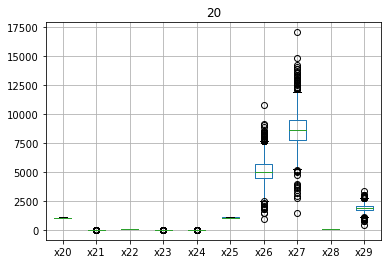

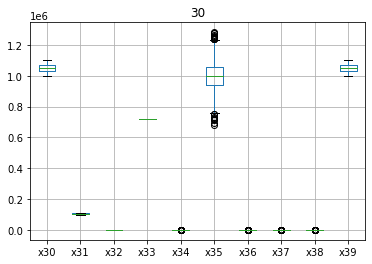

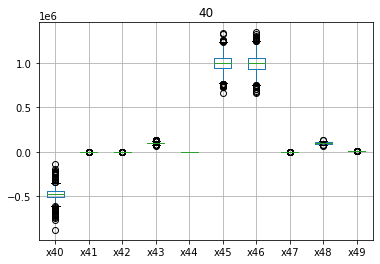

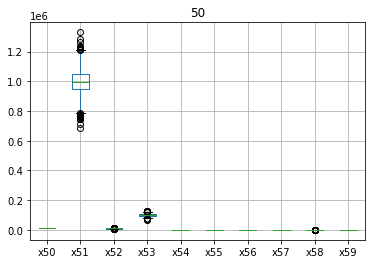

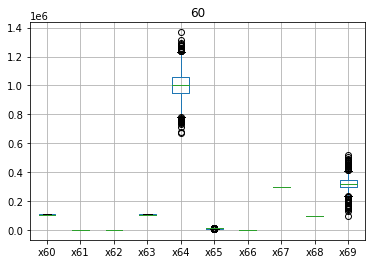

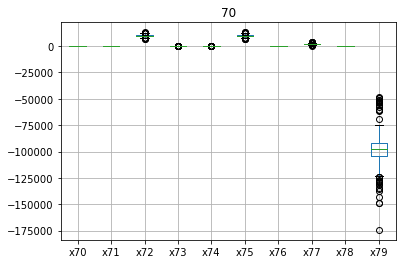

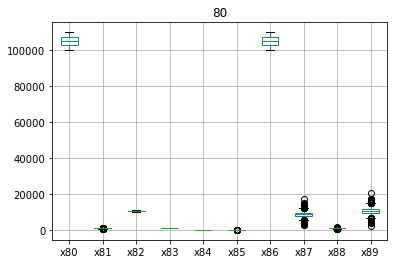

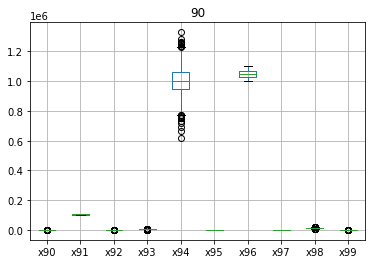

In [7]:
#boxplot of featues
for i in range(10):
    plt.figure()
    plt.title(i*10)
    x_train.iloc[:, i*10:(i+1)*10].boxplot()

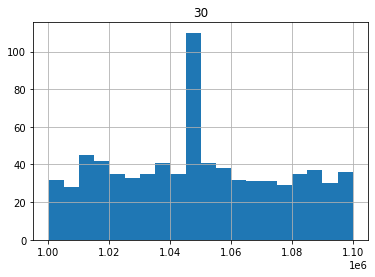

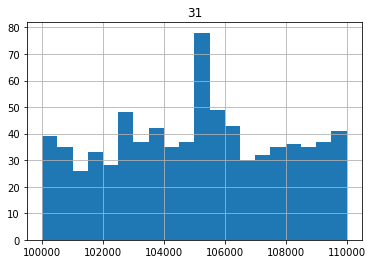

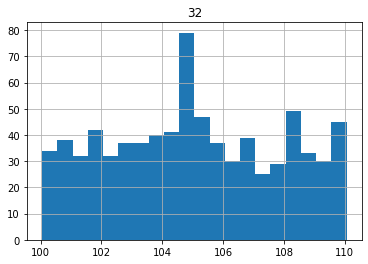

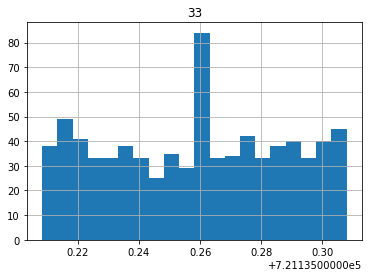

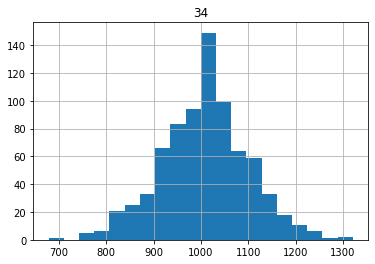

In [8]:
#histogram plot of features
for i in range(30,35):
    plt.figure()
    plt.title(i)
    x_test.iloc[:,i].hist(bins = 20)

'\ny = y_train.to_numpy().reshape(-1)\ny_hist = np.histogram(y, bins = 55)\ny_hist\n'

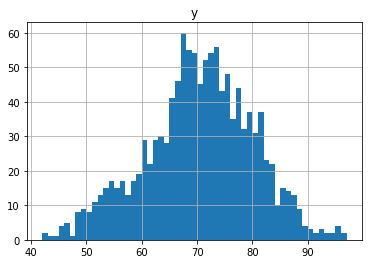

In [9]:
# age distribution of the training set 
# --> should we do something to balance this?
y_train.hist(bins=55)

# histogram arrray:
'''
y = y_train.to_numpy().reshape(-1)
y_hist = np.histogram(y, bins = 55)
y_hist
'''

## find all features with uniform looking histograms

when looking at the histograms one can notice that some features have uniform looking distributions. From a statistical perspective such features have no information value for predictions. Therfore it might my usefull to remove those features.

In [10]:
#removes features which have zero std_deviation
def remove_zero_std_features(x_train_, x_test_):
    zero_std = (x_train_.std() > 0.0)
    print("we remove ", x_train_.shape[1]-zero_std.sum(), "features")
    x_train_ = x_train_.loc[:, zero_std]
    x_test_ = x_test_.loc[:, zero_std]
    return x_train_, x_test_

x_train, x_test = remove_zero_std_features(x_train, x_test)

we remove  4 features


In [12]:
x = x_train.to_numpy()
chi_test = np.zeros(x.shape[1]) #stores a 1 if the feature is uniform like

#does the xhi_squared test for each feature and stores a 1 in test if p_value > 0.05
for i in range(x.shape[1]):
    hist = np.histogram(x[:,i], bins = 20)[0]
    hist = np.delete(hist,hist.argmax())
    unif = np.ones_like(hist)*hist.sum()/hist.shape
    if (chisquare(hist,unif).pvalue > 0.05):
        chi_test[i] = 1

print("we remove ", chi_test.sum(), "uniform looking features")
unif_cols_indicies = chi_test.nonzero()[0] #indices of uniform features
unif_cols_names = x_train.columns[unif_cols_indicies] #data frame column names of uniform features
x_train = x_train.drop(unif_cols_names, axis = 1) # drops these columns

we remove  217.0 uniform looking features


we found 217 features with uniform looking histograms. I ovserved this by measuring the p_value of the chi_squared test on the features. Note that I excluded the maximum value in each histogram as this value appears way more the all the other values (TODO: think about the consequenses of this later on!)
The indices which satisfy:
```python
test[i] == 1
```
are also the indices of the features which have histogram looking distributions.

## Standardization

In [11]:
# standardization of the data
std_scaler = StandardScaler()
# fit and transform the data
x_train = pd.DataFrame(std_scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(std_scaler.fit_transform(x_test), columns=x_test.columns)